# Analyzing the Expected Pocket Time
This notebook will dive into analysis methods that can be used as a way to quantify the efficeny of both the offensive line and defensive line and produce rankings.


In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator,StrMethodFormatter


#Load in the EPT dictionary (484 plays in which the ball was not passed; Hence, no EPT)
f = open('EPT_variables.pkl', 'rb')
ept = pickle.load(f)[0]

#Remove the frames in which the ball was not passed
no_pass = []
frames = list(ept.keys())
for fr in range(len(frames)):
    try:
        qc = ept[frames[fr]]['EPT']
    except KeyError:
        no_pass.append(fr)
no_pass = np.array(no_pass)
del_frames = np.array(frames)[no_pass]

#Remove if from the dictonary
for val in del_frames:
    if val in ept:
        del ept[val]
        
#Remove penalty plays
d = pd.read_csv('raw_data/plays.csv')
#Add in our gameId format
d['gameId_full'] = ['{}-{}'.format(d['gameId'].values[c],d['playId'].values[c]) for c in range(len(d))]

frames = list(ept.keys())
pen_frames = []
for frame in frames:
    if 'PENALTY' in str(d.loc[np.where(d['gameId_full']==frame)]['playDescription'].values):
        pen_frames.append(frame)

#Remove these plays from the dictionary
for pframe in pen_frames:
    del ept[pframe]

#Make the figure text larger
plt.rcParams.update({'font.size':18})

#Get player info
df_p = pd.read_csv('raw_data/players.csv')
df_t = pd.concat([pd.read_csv('raw_data/week{}.csv'.format(i)) for i in range(1,9)])
df_t.reset_index(inplace=True,drop=True)


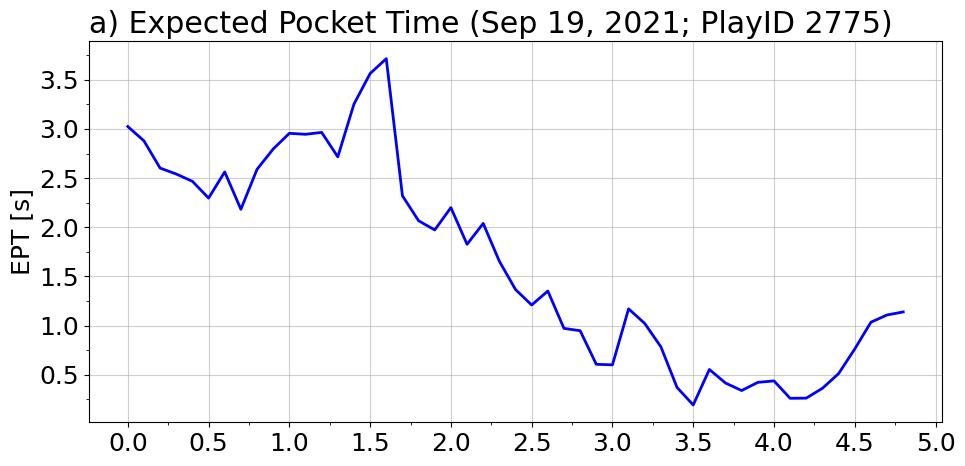

In [2]:
#Pick a frame at random and plot the total EPT
nums = np.array([1892,3306,4473,7500])

title_alpha = ['a)','b)','c)','d)']
for i in range(4):
    frames = list(ept.keys())
    rand = nums[i]#np.random.randint(len(frames))
    time_plot = np.arange(ept[frames[nums[i]]]['EPT'].size)/10

    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,1,1)
    plt.grid(alpha=0.6)

    val = np.array(frames)[nums][i]
    date_title = datetime.strptime(val.split('-')[0][:-2],'%Y%m%d').strftime('%b %d, %Y')
    plt.title('{} Expected Pocket Time ({}; PlayID {})'.format(title_alpha[i],date_title,val.split('-')[-1]),loc='left')

    ax.plot(time_plot,ept[frames[rand]]['EPT'],linewidth=2,color='blue')
    #ax.scatter(time_plot,ept[frames[rand]]['EPT'])

    #Format the axes
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))

    if i == 0:
        ax.set_ylabel('EPT [s]')
    elif i == 2:
        ax.set_xlabel('Play Duration [s]')
        ax.set_ylabel('EPT [s]')
    elif i == 3:
        ax.set_xlabel('Play Duration [s]')

    plt.tight_layout()
    #plt.savefig('figures/EPT_{}.png'.format(np.array(frames)[nums][i]),dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
    
    break
    


# Some thoughts going into the analysis

1) If the first value of the time series is the expected pocket time, yet if the play ended much earlier, why was this the case? Did the QB have ebough time to throw the ball or was he forced to throw it? 

2) How do time series of EPT look when the QB is forced to throw the ball rather than throw the ball on his terms?

3) Does the rate at which the time decreases have any insight into the play itself qualitatively? (the "normal" slope should be on the order of the the native temporal resolution of the data $\sim$ 0.1 s).

4) The irregularities of the time series relative to the "normal slope" should provide signal into each lineman's performace for that play. How many seconds did each lineman add or subtract from the play? This will be the basis for our index to evaluate the efficiency of the offensive and defensive line. 

5) Compare our results with the PBWR and PPF's lineman rankings to make sure we are all on the same page with rankings both subjectively and objectively.

Here is our corresponding analysis:

'Ben Powers'

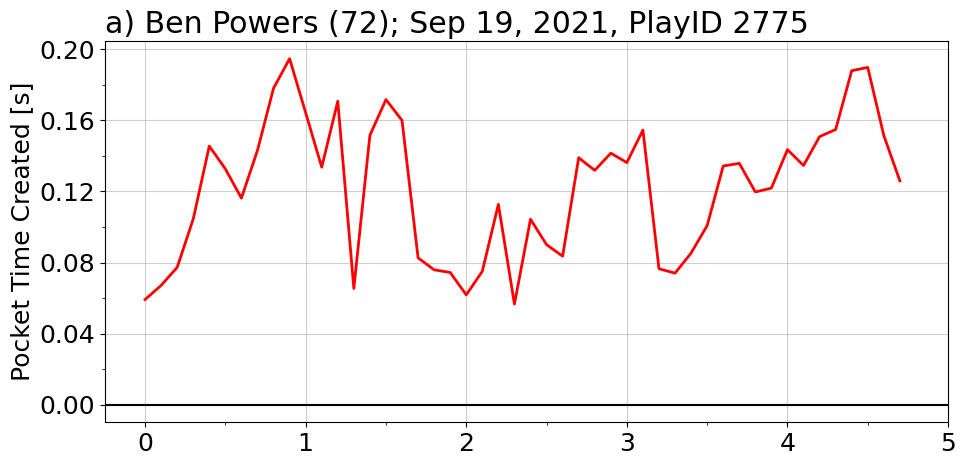

In [241]:
#Plot each individual player's time series
i = 0

decomp_dict = ept[frames[nums[i]]]['EPT_decomp']
EPT_dict = ept[frames[nums[i]]]['EPT']

#List of all the player IDs and get their positions
playerIDs = decomp_dict.keys()
player_pos = np.array([df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition'] for val in playerIDs])
jersey_num = np.array([df_t.loc[np.where(df_t.nflId==int(float(val)))[0][0]]['jerseyNumber'] for val in playerIDs])

#Start the figure
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
plt.grid(alpha=0.6)

#Set the title
val = np.array(frames)[nums][i]
date_title = datetime.strptime(val.split('-')[0][:-2],'%Y%m%d').strftime('%b %d, %Y')
jersey_num_init = 72 #55
player_name_plot = df_p.loc[np.where(df_p.nflId==int(float(np.array(list(playerIDs))[np.where(jersey_num==jersey_num_init)[0][0]])))]['displayName'].values[0]
plt.title('a) {} ({:.0f}); {}, PlayID {}'.format(player_name_plot,jersey_num_init,date_title,val.split('-')[-1]),loc='left')

time_plot = np.arange(ept[frames[nums[i]]]['EPT'].size)/10
colors = ['red','darkorange','magenta','purple','green','gold','blue','k','pink']


#Compute the EPT metric
sumss_o = np.zeros((len(playerIDs)))*np.nan
sumss_d = np.zeros((len(playerIDs)))*np.nan
for c,key in enumerate(playerIDs):
    if (player_pos[c]=='C') or (player_pos[c]=='G') or (player_pos[c]=='T'):
        area = (decomp_dict[key]-EPT_dict)*0.1
        aarea = np.zeros((area.size))*np.nan
        for count,a in enumerate(area):
            if a > 0:
                aarea[count] = a**0.5
            else:
                aarea[count] = (np.abs(a)**0.5)*-1
        
        sumss_o[c] = np.sum(aarea)

    elif (player_pos[c]=='DT') or (player_pos[c]=='DE') or (player_pos[c]=='NT'):
        area = (decomp_dict[key]-EPT_dict)*0.1
        aarea = np.zeros((area.size))*np.nan
        for count,a in enumerate(area):
            if a > 0:
                aarea[count] = a**0.5
            else:
                aarea[count] = (np.abs(a)**0.5)*-1
        
        sumss_d[c] = np.sum(aarea)#*len(EPT_dict)#/ time_plot[-1])

#Weight the metric
#sumss_o = ((sumss_o/np.nansum(sumss_o))*100) #- (100/(len(sumss_o)-np.where(np.isnan(sumss_o))[0].size))
#sumss_d = ((sumss_d/(1/np.nansum(sumss_d)))*100) #-  (100/(len(sumss_o)-np.where(np.isnan(sumss_o))[0].size))

sumss = np.zeros((len(playerIDs)))*np.nan
for c,key in enumerate(playerIDs):
    if jersey_num[c] == jersey_num_init:
        if (player_pos[c]=='C') or (player_pos[c]=='G') or (player_pos[c]=='T'):
            ax.plot(time_plot[:-1],decomp_dict[key][:-1]-EPT_dict[:-1],linewidth=2,linestyle='solid',color='red',label='{:.2f} ({:.0f})'.format(sumss_o[c],jersey_num[c]))
            sumss[c] = sumss_o[c]
        elif (player_pos[c]=='DE') or (player_pos[c]=='DT') or (player_pos[c]=='NT'):
            ax.plot(time_plot[:-1],decomp_dict[key][:-1]-EPT_dict[:-1],linewidth=2,linestyle='solid',color='blue',label='{:.2f} ({:.0f})'.format(sumss_d[c],jersey_num[c]))
            sumss[c] = sumss_d[c]

#Plot the baseline
ax.hlines(y=0,color='k',xmax=5,xmin=-0.25)

#Format the axes
ax.yaxis.set_major_locator(MultipleLocator(0.04))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    
#Sort the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(sumss)[::-1]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right',framealpha=0,fontsize=14)

ax.set_ylabel('Pocket Time Created [s]')
#ax.set_xlabel('Play Duration [s]')
ax.set_xlim([-0.25,5])
#ax.set_ylim([-0.2,0.4])

plt.tight_layout()
plt.savefig('Pocket_Preservation_Index/figures/ept_decomp_{}.png'.format(jersey_num_init),dpi=300,bbox_inches='tight')
plt.show()
plt.close()


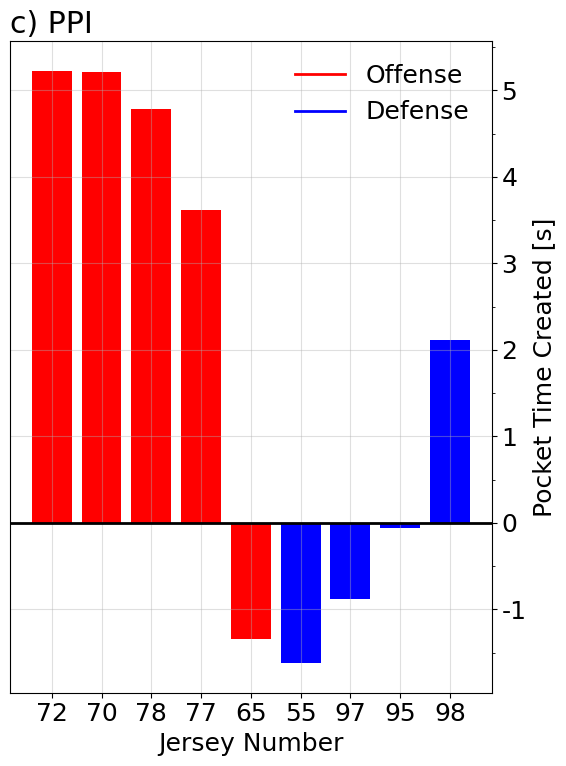

In [238]:
plt.figure(figsize=(6,8))
ax = plt.subplot(1,1,1)
plt.grid(alpha=0.4)
plt.title('c) PPI',loc='left')

#Sort offense
ioff = np.where((player_pos=='C')|(player_pos=='G')|(player_pos=='T'))
summs_off = sumss[ioff]
sort_off = np.argsort(summs_off)[::-1]
summs_off = summs_off[sort_off]
jersey_off = jersey_num[ioff][sort_off]
player_pos_off = player_pos[ioff][sort_off]

#Sort defense
ideff = np.where((player_pos=='DE')|(player_pos=='DT')|(player_pos=='NT'))
summs_def = sumss[ideff]
sort_def = np.argsort(summs_def)
summs_def = summs_def[sort_def]
jersey_def = jersey_num[ideff][sort_def]
player_pos_def = player_pos[ideff][sort_def]

#Append all together for plotting
summs_plot = np.append(summs_off,summs_def)
jersey_plot = np.append(jersey_off,jersey_def)
player_pos_plot = np.append(player_pos_off,player_pos_def)

for c in range(len(summs_plot)):
    if player_pos_plot[c] in ['C','G','T']:
        ax.bar(c,summs_plot[c],color='red')
    else:
        ax.bar(c,summs_plot[c],color='blue')

ax.axhline(y=0,color='k',linewidth=2)
ax.set_xticks(np.arange(len(summs_plot)),jersey_plot.astype(int))

ax.plot([0,1],[5,4],color='red',alpha=0,label='Offense',linewidth=2)
ax.plot([0,1],[4,3],color='blue',alpha=0,label='Defense',linewidth=2)

#Format the axes
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position('right')

ax.set_ylabel('Pocket Time Created [s]')
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set_xlabel('Jersey Number')

#Legend
leg = ax.legend(loc='upper right',framealpha=0)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.savefig('Pocket_Preservation_Index/figures/bar_chart.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()


In [242]:
summs_plot

array([ 5.22467424,  5.20732901,  4.78264398,  3.62112816, -1.33758232,
       -1.62163035, -0.88103527, -0.06078126,  2.11848118])

In [36]:
#Assign team names to each player we will analyze
dt_pids = np.unique(df_t.nflId.values)
dt_pids = dt_pids[~np.isnan(dt_pids)]
dt_team = np.array([df_t.team.values[np.where(df_t.nflId.values==float(val))[0][0]] for val in dt_pids])


In [127]:
#Use this logic to create rankings per player
plays = list(ept.keys())
ept_rankings = {}
team_ept_rankings = {}
team_ept_rankings['offense'] = {}
team_ept_rankings['defense'] = {}
games_tot = {}

for f in tqdm(frames,total=len(plays)):
    date_frame = datetime.strptime(f.split('-')[0][:-2],'%Y%m%d')
    #if date_frame <= datetime(2021,9,13):
    
    time = np.arange(ept[f]['EPT'].size)/10

    #Grab list of players, their positions, and teams for this play
    playerIDs = list(ept[f]['EPT_ave'].keys())
    player_pos = np.array([df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition'] for val in playerIDs])
    player_team = np.array([dt_team[np.where(dt_pids==int(float(val)))[0][0]] for val in playerIDs])    
    
    #Initialize arrays to be used
    sumss_o,team_o = np.zeros((len(playerIDs)))*np.nan, []
    sumss_d,team_d = np.zeros((len(playerIDs)))*np.nan, []
    
    #Iterate through each player ID
    for c,key in enumerate(playerIDs):
        
        #Compute the metric
        if (player_pos[c]=='C') or (player_pos[c]=='G') or (player_pos[c]=='T'):
            area = (ept[f]['EPT_decomp'][key]-ept[f]['EPT'])*0.1
            aarea = np.zeros((area.size))*np.nan
            for count,a in enumerate(area):
                if a > 0:
                    aarea[count] = a**0.5
                else:
                    aarea[count] = (np.abs(a)**0.5)*-1

            sumss_o[c] = np.sum(aarea)
            #sumss_o[c] = (np.sum(ept[f]['EPT_decomp'][key]-ept[f]['EPT'])) / time_plot[-1]
            team_o.append(player_team[c])
            
        elif (player_pos[c]=='DT') or (player_pos[c]=='DE') or (player_pos[c]=='NT'):
            area = (ept[f]['EPT_decomp'][key]-ept[f]['EPT'])*0.1
            aarea = np.zeros((area.size))*np.nan
            for count,a in enumerate(area):
                if a > 0:
                    aarea[count] = a**0.5
                else:
                    aarea[count] = (np.abs(a)**0.5)*-1

            sumss_d[c] = np.sum(aarea)
            #sumss_d[c] = (np.sum(ept[f]['EPT_decomp'][key]-ept[f]['EPT'])) / time[-1]
            team_d.append(player_team[c])
            
    #Append to the team dictionary
    if len(team_o)>0:
        try:
            qc = team_ept_rankings['offense'][team_o[0]]
            team_ept_rankings['offense'][team_o[0]] = np.append(team_ept_rankings['offense'][team_o[0]],np.nanmean(sumss_o))
        except KeyError:
            team_ept_rankings['offense'][team_o[0]] = np.nanmean(sumss_o)
        
    if len(team_d)>0:
        try:
            qc = team_ept_rankings['defense'][team_d[0]]
            team_ept_rankings['defense'][team_d[0]] = np.append(team_ept_rankings['defense'][team_d[0]],np.nanmean(sumss_d))
        except KeyError:
            team_ept_rankings['defense'][team_d[0]] = np.nanmean(sumss_d)
    
    #Append by player
    for c,key in enumerate(playerIDs):
        if (player_pos[c]=='C') or (player_pos[c]=='G') or (player_pos[c]=='T'): 
            
            try:
                qc = ept_rankings[key]
                ept_rankings[key] = np.append(ept_rankings[key],sumss_o[c])
                games_tot[key] = np.append(games_tot[key],f.split('-')[0])
            except KeyError:
                ept_rankings[key] = sumss_o[c]
                games_tot[key] = f.split('-')[0]
        
        elif (player_pos[c]=='DT') or (player_pos[c]=='DE') or (player_pos[c]=='NT'):
            try:
                qc = ept_rankings[key]
                ept_rankings[key] = np.append(ept_rankings[key],sumss_d[c])
                games_tot[key] = np.append(games_tot[key],f.split('-')[0])
            except KeyError:
                ept_rankings[key] = sumss_d[c]
                games_tot[key] = f.split('-')[0]

#Remove players that have lower than 75 passing plays
pass_atempts = 75
bad_players = []
for i,p in enumerate(list(ept_rankings.keys())):
    if ept_rankings[p].size < pass_atempts:
        del ept_rankings[p]
        bad_players.append(p)


100%|█████████████████████████████████████████████████████████████████████████████████████| 7507/7507 [00:15<00:00, 473.68it/s]


In [128]:
#Run this block of code again and remove the bad players
plays = list(ept.keys())
ept_rankings = {}
team_ept_rankings = {}
team_ept_rankings['offense'] = {}
team_ept_rankings['defense'] = {}
games_tot = {}

for f in tqdm(frames,total=len(plays)):
    date_frame = datetime.strptime(f.split('-')[0][:-2],'%Y%m%d')
    #if date_frame <= datetime(2021,9,13):
    
    time = np.arange(ept[f]['EPT'].size)/10

    #Iterate through each player ID
    playerIDs = list(ept[f]['EPT_ave'].keys())
    
    #Remove the players with small sample sizes
    for val in bad_players:
        try:
            del playerIDs[playerIDs.index(val)]
        except ValueError:
            pass
    
    player_pos = np.array([df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition'] for val in playerIDs])
    player_team = np.array([dt_team[np.where(dt_pids==int(float(val)))[0][0]] for val in playerIDs])    
    
    sumss_o,team_o = np.zeros((len(playerIDs)))*np.nan, []
    sumss_d,team_d = np.zeros((len(playerIDs)))*np.nan, []
    for c,key in enumerate(playerIDs):
        
        #Compute the metric
        if (player_pos[c]=='C') or (player_pos[c]=='G') or (player_pos[c]=='T'):
            area = (ept[f]['EPT_decomp'][key]-ept[f]['EPT'])*0.1
            aarea = np.zeros((area.size))*np.nan
            for count,a in enumerate(area):
                if a > 0:
                    aarea[count] = a**0.5
                else:
                    aarea[count] = (np.abs(a)**0.5)*-1

            sumss_o[c] = np.sum(aarea)
            #sumss_o[c] = (np.sum(ept[f]['EPT_decomp'][key]-ept[f]['EPT'])) / time_plot[-1]
            team_o.append(player_team[c])
            
        elif (player_pos[c]=='DT') or (player_pos[c]=='DE') or (player_pos[c]=='NT'):
            area = (ept[f]['EPT_decomp'][key]-ept[f]['EPT'])*0.1
            aarea = np.zeros((area.size))*np.nan
            for count,a in enumerate(area):
                if a > 0:
                    aarea[count] = a**0.5
                else:
                    aarea[count] = (np.abs(a)**0.5)*-1

            sumss_d[c] = np.sum(aarea)
            #sumss_d[c] = (np.sum(ept[f]['EPT_decomp'][key]-ept[f]['EPT'])) / time[-1]
            team_d.append(player_team[c])
    
    #Append to the team dictionary
    if len(team_o)>0:
        try:
            qc = team_ept_rankings['offense'][team_o[0]]
            team_ept_rankings['offense'][team_o[0]] = np.append(team_ept_rankings['offense'][team_o[0]],np.nanmean(sumss_o))
        except KeyError:
            team_ept_rankings['offense'][team_o[0]] = np.nanmean(sumss_o)
        
    if len(team_d)>0:
        try:
            qc = team_ept_rankings['defense'][team_d[0]]
            team_ept_rankings['defense'][team_d[0]] = np.append(team_ept_rankings['defense'][team_d[0]],np.nanmean(sumss_d))
        except KeyError:
            team_ept_rankings['defense'][team_d[0]] = np.nanmean(sumss_d)
        
        
    #Append by player
    for c,key in enumerate(playerIDs):
        if (player_pos[c]=='C') or (player_pos[c]=='G') or (player_pos[c]=='T'): 
            
            try:
                qc = ept_rankings[key]
                ept_rankings[key] = np.append(ept_rankings[key],sumss_o[c])
                games_tot[key] = np.append(games_tot[key],f.split('-')[0])
            except KeyError:
                ept_rankings[key] = sumss_o[c]
                games_tot[key] = f.split('-')[0]
        
        elif (player_pos[c]=='DT') or (player_pos[c]=='DE') or (player_pos[c]=='NT'):
            try:
                qc = ept_rankings[key]
                ept_rankings[key] = np.append(ept_rankings[key],sumss_d[c])
                games_tot[key] = np.append(games_tot[key],f.split('-')[0])
            except KeyError:
                ept_rankings[key] = sumss_d[c]
                games_tot[key] = f.split('-')[0]


100%|█████████████████████████████████████████████████████████████████████████████████████| 7507/7507 [00:14<00:00, 508.09it/s]


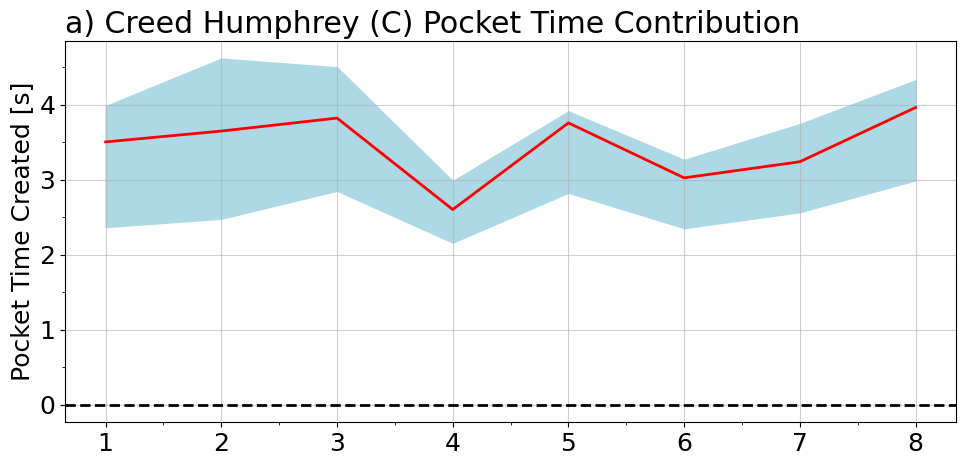

In [96]:
#Visualize this data
name = 'Creed Humphrey' #'Myles Garrett' #
pids = np.unique(np.array(list(ept_rankings.keys())))
pids = pids[np.where(pids==str(float(df_p.loc[np.where(df_p.displayName==name)[0][0]]['nflId'])))[0][0]]
pid = pids

#Create the moving average
gameIDs = np.unique(games_tot[pid])
igame = np.array([np.where(games_tot[pid]==f)[0][0] for f in gameIDs])
ma = np.zeros((igame.size))*np.nan
p25,p75 = np.zeros((igame.size))*np.nan,np.zeros((igame.size))*np.nan
for i in range(igame.size):
    if i < igame.size-1:
        ma[i] = np.nanmean(ept_rankings[str(pid)][igame[i]:igame[i+1]+1])
        p25[i] = np.percentile(ept_rankings[str(pid)][igame[i]:igame[i+1]+1],25)
        p75[i] = np.percentile(ept_rankings[str(pid)][igame[i]:igame[i+1]+1],75)
    if i == igame.size-1:
        ma[i] = np.nanmean(ept_rankings[str(pid)][igame[i]:])
        p25[i] = np.percentile(ept_rankings[str(pid)][igame[i]:],25)
        p75[i] = np.percentile(ept_rankings[str(pid)][igame[i]:],75)
        
igame = np.append(igame,ept_rankings[str(pid)].size)

#Create the figure
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
plt.grid(alpha=0.6)

name = df_p.loc[np.where(df_p.nflId==float(pid))[0][0]]['displayName']
pos = df_p.loc[np.where(df_p.nflId==float(pid))[0][0]]['officialPosition']
plt.title('a) {} ({}) Pocket Time Contribution'.format(name,pos),loc='left')

x_plot = np.arange(1,igame[1:].size+1)
ax.fill_between(x_plot,p25,p75,color='lightblue')
ax.plot(x_plot,ma,color='red',linewidth=2,label='Moving Average by Game')
ax.axhline(y=0,color='k',linewidth=2,linestyle='dashed')


#Format the axes
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    
#plt.xlabel('Week Number')
plt.ylabel('Pocket Time Created [s]')
#plt.legend(framealpha=0,fontsize=18)

plt.tight_layout()
plt.savefig('Pocket_Preservation_Index/figures/{}_{}_EPT.png'.format(name.split(' ')[0],name.split(' ')[-1]),dpi=300,bbox_inches='tight')
plt.show()



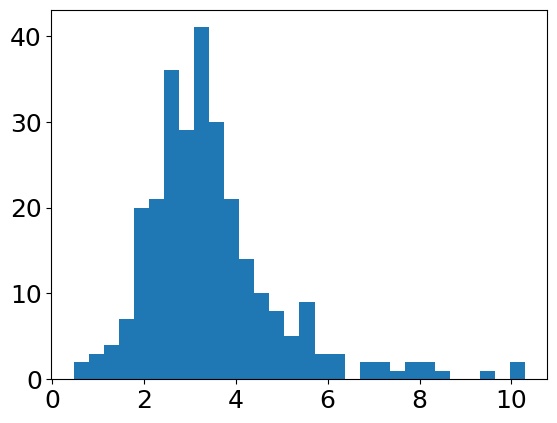

2.213334076114744

In [41]:
#Produce a quick histogram showing his distribution of time created or lost
plt.hist(ept_rankings[str(pid)],bins=30)
plt.show()

np.nanvar(ept_rankings[str(pid)])

# Some Observations

1) These series of player performace by play gives insight into consistency and performance
2) Going forward, would it be best to take the average value? To integrate? 

In [42]:
#Break up the ranking by position

#Get player positions for each player ID
pids = np.array(list(ept_rankings.keys()))
player_pos = np.array([df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition'] for val in pids])
player_team = np.array([df_t.loc[np.where(df_t.nflId==int(float(val)))[0][0]]['team'] for val in pids])

pos_distr,obs_pos = [],[]
for c,pos in enumerate(np.unique(player_pos)):
    
    #Get the series of EPT rank for these players in this position
    tot_players = pids[np.where(player_pos==pos)[0]]
    tot_team = np.array([df_t.loc[np.where(df_t.nflId==int(float(val)))[0][0]]['team'] for val in tot_players])
    ave_pos,ave_sample,var = np.zeros((tot_players.size))*np.nan,np.zeros((tot_players.size))*np.nan,np.zeros((tot_players.size))*np.nan
    tm_ = np.zeros((tot_players.size)).astype(object)*np.nan
    ave_ept = []
    for i,p in enumerate(tot_players):
        ave_pos[i] = np.nanmedian(ept_rankings[p])
        ave_sample[i] = len(ept_rankings[p])
        var[i] = np.nanvar(ept_rankings[p])
        tm_[i] = tot_team[i]
        ave_ept.append(ept_rankings[p])
    ave_ept = [x for l in ave_ept for x in l]
    pos_distr.append(np.array(ave_ept))
    obs_pos.append(pos)
    
    #Print the top 10 players
    if (pos=='C') or (pos=='G') or (pos=='T'):
        sortt = np.argsort(ave_pos)[::-1] #Large to small
    elif (pos=='DT') or (pos=='DE') or (pos=='NT'):
        sortt = np.argsort(ave_pos) #Small to large
    
    rank_10 = tot_players[sortt[:10]]
    ave_ept = np.nanmedian(ave_ept)
    print('----------------Top 10 Scores ({}, {:.2f})----------------'.format(pos,ave_ept))
    for i,val in enumerate(rank_10):
        name = df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['displayName']
        pos = df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition']
        print('{}: {} {}, {:.0f}\t{:.2f} [{:.2f}]'.format(i+1,name,tm_[sortt[:10]][i],ave_sample[sortt[:10]][i],ave_pos[sortt[:10]][i],var[sortt[:10]][i]))
    print()

obs_pos = np.array(obs_pos)


----------------Top 10 Scores (C, 3.05)----------------
1: Max Garcia ARI, 99	3.64 [1.83]
2: Rodney Hudson ARI, 126	3.59 [2.39]
3: Bradley Bozeman BAL, 218	3.49 [1.58]
4: Ryan Kelly IND, 223	3.36 [1.48]
5: Chase Roullier WAS, 228	3.31 [1.46]
6: Mitch Morse BUF, 217	3.31 [1.38]
7: Jason Kelce PHI, 207	3.31 [2.01]
8: Creed Humphrey KC, 279	3.23 [2.21]
9: J.C. Tretter CLE, 217	3.23 [1.74]
10: Connor McGovern NYJ, 245	3.18 [2.12]

----------------Top 10 Scores (DE, -0.22)----------------
1: Darrell Taylor SEA, 108	-1.19 [2.16]
2: Brian Burns CAR, 196	-1.03 [2.57]
3: Montez Sweat WAS, 200	-0.83 [2.11]
4: Sam Hubbard CIN, 228	-0.83 [2.23]
5: Takkarist McKinley CLE, 112	-0.82 [2.14]
6: Myles Garrett CLE, 182	-0.79 [1.90]
7: Mario Addison BUF, 94	-0.78 [2.30]
8: Everson Griffen MIN, 150	-0.78 [2.19]
9: Alex Okafor KC, 110	-0.75 [3.39]
10: Cameron Jordan NO, 197	-0.71 [2.26]

----------------Top 10 Scores (DT, 0.65)----------------
1: Chris Jones KC, 131	-0.05 [2.33]
2: Aaron Donald LA, 232	-0.

In [210]:
pos_distr[np.where(obs_pos=='C')[0][0]].size,pos_distr[np.where(obs_pos=='G')[0][0]].size

(6931, 13835)

In [214]:
#Significance testing for difference of means
import scipy


irand = np.random.choice(np.arange(pos_distr[np.where(obs_pos=='G')[0][0]].size),size=pos_distr[np.where(obs_pos=='C')[0][0]].size)
dist1 = pos_distr[np.where(obs_pos=='G')[0][0]][irand]
dist0 = pos_distr[np.where(obs_pos=='C')[0][0]]


scipy.stats.f_oneway(dist0, dist1)


F_onewayResult(statistic=29.148473463696288, pvalue=6.814296079584164e-08)

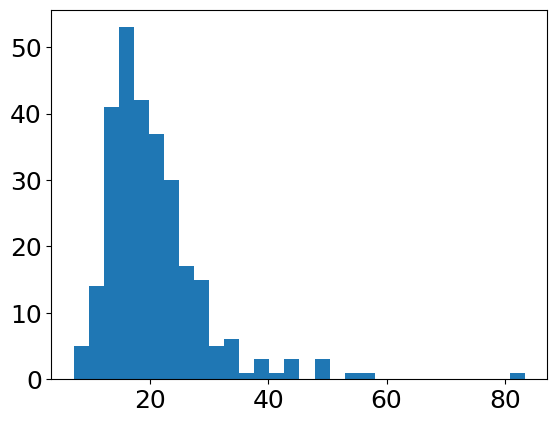

76.08403792031662

In [16]:
plt.hist(team_ept_rankings['offense']['KC'],bins=30)
plt.show()

np.nanvar(team_ept_rankings['offense']['KC'])

In [129]:
teams = np.array(list(team_ept_rankings['offense'].keys()))
team_ave = np.array([np.nanmedian(team_ept_rankings['offense'][tm]) for tm in teams])
team_var = np.array([np.nanvar(team_ept_rankings['offense'][tm]) for tm in teams])
team_size = np.array([team_ept_rankings['offense'][tm].size for tm in teams])

#Sort from high to low
sortt = np.argsort(team_ave)[::-1]
sort_teams,sort_var,sort_size,sort_vals = teams[sortt],team_var[sortt],team_size[sortt],team_ave[sortt]
opac = np.arange(7,103,3)[::-1]
print('----------------Ranked Offensive Line----------------')
[print('{}: {}\t{}, {:.2f}, {:.2f}'.format(i+1,sort_teams[i],int(sort_size[i]),sort_vals[i],sort_var[i])) for i in range(len(sort_teams))]
print()



----------------Ranked Offensive Line----------------
1: ARI	205, 3.11, 1.45
2: BAL	236, 3.10, 1.27
3: PHI	207, 2.92, 1.36
4: KC	279, 2.90, 1.49
5: CLE	217, 2.88, 1.18
6: WAS	252, 2.85, 0.91
7: NO	169, 2.84, 1.53
8: LA	233, 2.82, 0.73
9: NYJ	245, 2.82, 1.07
10: BUF	219, 2.79, 0.94
11: GB	203, 2.77, 1.49
12: MIA	266, 2.71, 0.70
13: DEN	265, 2.68, 0.85
14: DAL	224, 2.68, 0.97
15: CHI	203, 2.68, 1.10
16: DET	292, 2.68, 0.97
17: LV	235, 2.67, 0.82
18: CAR	258, 2.66, 1.22
19: NYG	255, 2.65, 0.91
20: JAX	234, 2.64, 1.26
21: SEA	197, 2.63, 1.20
22: HOU	218, 2.63, 0.89
23: IND	223, 2.61, 1.01
24: TB	293, 2.61, 0.66
25: CIN	235, 2.60, 0.72
26: LAC	245, 2.59, 1.16
27: NE	259, 2.58, 1.00
28: PIT	223, 2.56, 0.66
29: SF	186, 2.55, 1.16
30: MIN	228, 2.49, 0.58
31: ATL	255, 2.44, 0.65
32: TEN	248, 2.39, 0.58



In [130]:
#Rank teams by summing up their Oline through each play
teams = np.array(list(team_ept_rankings['defense'].keys()))
team_ave = np.array([np.nanmedian(team_ept_rankings['defense'][tm]) for tm in teams])
team_var = np.array([np.nanvar(team_ept_rankings['defense'][tm]) for tm in teams])
team_size = np.array([team_ept_rankings['defense'][tm].size for tm in teams])

#Sort from high to low
sortt = np.argsort(team_ave)
sort_teams,sort_var,sort_size,sort_vals = teams[sortt],team_var[sortt],team_size[sortt],team_ave[sortt]
opac = np.arange(7,103,3)[::-1]
print('----------------Ranked Defensive Line----------------')
[print('{}: {}\t{}, {:.2f}, {:.2f}'.format(i+1,sort_teams[i],int(sort_size[i]),sort_vals[i],sort_var[i])) for i in range(len(sort_teams))]
print()


----------------Ranked Defensive Line----------------
1: DAL	203, -0.28, 1.12
2: CLE	223, -0.22, 0.75
3: MIN	220, -0.17, 0.70
4: WAS	276, -0.08, 0.79
5: NYJ	225, -0.04, 0.73
6: BUF	201, -0.04, 0.98
7: NO	235, -0.02, 1.12
8: CAR	229, -0.02, 0.99
9: SF	186, 0.01, 1.16
10: PHI	221, 0.09, 0.90
11: IND	235, 0.10, 1.02
12: LV	241, 0.11, 0.67
13: CIN	297, 0.11, 0.67
14: ARI	196, 0.13, 1.58
15: HOU	206, 0.16, 0.92
16: TB	277, 0.20, 0.81
17: SEA	272, 0.21, 1.09
18: LA	262, 0.22, 1.23
19: KC	225, 0.22, 0.89
20: MIA	268, 0.22, 0.93
21: LAC	194, 0.40, 0.93
22: JAX	192, 0.44, 2.00
23: NE	241, 0.52, 1.42
24: BAL	227, 0.52, 1.57
25: DEN	232, 0.56, 1.31
26: ATL	151, 0.58, 1.85
27: GB	246, 0.63, 1.37
28: PIT	223, 0.65, 1.37
29: NYG	252, 0.66, 1.60
30: CHI	201, 0.67, 1.29
31: TEN	241, 0.68, 1.45
32: DET	158, 0.71, 2.12



In [148]:
#Break up the ranking by Oline players

#Get player positions for each player ID
player_pos = np.array([df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition'] for val in pids])
    
#Get the series of EPT rank for these players in the Offensive line positions
tot_players = pids[np.where((player_pos=='C')|(player_pos=='G')|(player_pos=='T'))[0]]
ave_pos = np.zeros((tot_players.size))*np.nan

#Loop through each player
for i,p in enumerate(tot_players):
    ave_pos[i] = np.nanmean(ept_rankings[p]) #Get their series

#Print the top 10 players
sortt = np.argsort(ave_pos)[::-1]
rank_10 = tot_players[sortt]
print('----------------Top Offensive Lineman----------------')
for i,val in enumerate(rank_10):
    name = df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['displayName']
    pos = df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition']
    print('{}: {}\t{:.2f}'.format(i+1,name,ave_pos[sortt][i]))
print()

----------------Top Offensive Lineman----------------
1: Erik McCoy	1.72
2: Max Garcia	1.68
3: Kendrick Green	1.65
4: Wes Martin	1.62
5: Isaac Seumalo	1.60
6: Creed Humphrey	1.60
7: Mitch Morse	1.60
8: Tyler Shatley	1.60
9: Rodney Hudson	1.60
10: Austin Reiter	1.60
11: Nate Herbig	1.59
12: Brandon Linder	1.59
13: Chase Roullier	1.58
14: Trey Smith	1.58
15: Kevin Zeitler	1.57
16: Zack Martin	1.57
17: Frank Ragnow	1.57
18: Trai Turner	1.57
19: Wyatt Teller	1.57
20: Josh Myers	1.57
21: J.C. Tretter	1.56
22: Joe Haeg	1.56
23: Brian Allen	1.56
24: Justin Pugh	1.55
25: Trey Hopkins	1.55
26: Brandon Brooks	1.55
27: Trenton Scott	1.55
28: Tyler Biadasz	1.54
29: Kevin Dotson	1.54
30: Joe Thuney	1.54
31: David Edwards	1.54
32: Billy Price	1.54
33: Greg Mancz	1.53
34: Kyle Fuller	1.53
35: David Andrews	1.53
36: Justin Britt	1.53
37: Ben Bredeson	1.53
38: Oday Aboushi	1.52
39: James Ferentz	1.52
40: Joel Bitonio	1.52
41: Alex Cappa	1.52
42: Austin Corbett	1.52
43: Corey Linsley	1.51
44: Lucas Patr

In [150]:
#Break up the ranking by Oline and Dline players

#Get player positions for each player ID
player_pos = np.array([df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition'] for val in pids])
    
#Get the series of EPT rank for these players in this position
tot_players = pids[np.where((player_pos=='DT')|(player_pos=='DE')|(player_pos=='NT'))[0]]
ave_pos = np.zeros((tot_players.size))*np.nan
for i,p in enumerate(tot_players):
    ave_pos[i] = np.nanmean(ept_rankings[p])

#Print the top 10 players
sortt = np.argsort(ave_pos)
rank_10 = tot_players[sortt]
print('----------------Top Defensive Lineman----------------')
for i,val in enumerate(rank_10):
    name = df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['displayName']
    pos = df_p.loc[np.where(df_p.nflId==int(float(val)))[0][0]]['officialPosition']
    print('{}: {}\t{:.2f}'.format(i+1,name,ave_pos[sortt][i]))
print()

----------------Top Defensive Lineman----------------
1: Alton Robinson	-0.57
2: Brian Burns	-0.48
3: Darrell Taylor	-0.47
4: Wyatt Ray	-0.43
5: Mario Addison	-0.42
6: Myles Garrett	-0.39
7: Dee Ford	-0.37
8: Takkarist McKinley	-0.36
9: Montez Sweat	-0.34
10: Shaq Lawson	-0.32
11: Sam Hubbard	-0.32
12: Jason Pierre-Paul	-0.31
13: Alex Okafor	-0.30
14: Randy Gregory	-0.29
15: Yannick Ngakoue	-0.29
16: Marquis Haynes	-0.29
17: Trey Hendrickson	-0.29
18: Jacob Martin	-0.28
19: A.J. Epenesa	-0.28
20: D.J. Wonnum	-0.26
21: Gregory Rousseau	-0.26
22: James Smith-Williams	-0.26
23: Everson Griffen	-0.24
24: Chase Young	-0.24
25: Josh Sweat	-0.24
26: Kwity Paye	-0.23
27: Cameron Jordan	-0.23
28: Tarell Basham	-0.23
29: Derek Barnett	-0.23
30: Danielle Hunter	-0.23
31: Ben Banogu	-0.22
32: Jadeveon Clowney	-0.22
33: Michael Danna	-0.22
34: Chase Winovich	-0.22
35: Bryce Huff	-0.22
36: Whitney Mercilus	-0.21
37: Arden Key	-0.20
38: Jerry Hughes	-0.19
39: Al-Quadin Muhammad	-0.18
40: Dorance Arms